# Titanic: Machine Learning from Disaster

Model to predict who would survive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Preprocessing the Data

In [5]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [6]:
# apply all functions above
def process_df(df):
    df = process_cabin(process_titles(process_fare(process_age(process_missing(df)))))
    for i in ["Age_categories", "Fare_categories","Title", "Cabin_type", "Sex"]:
        df = create_dummies(df,i)
    return df
train = process_df(train)
holdout = process_df(holdout)

### Exploring the Data

SibSp and Parch

In [9]:
columns = ['SibSp','Parch']
train[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 2 columns):
SibSp    891 non-null int64
Parch    891 non-null int64
dtypes: int64(2)
memory usage: 14.0 KB


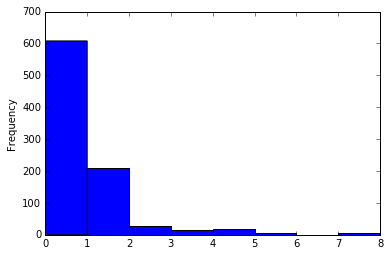

In [14]:
train['SibSp'].plot.hist(bins = 8)

range between 0 and 8. most of the passangers were alone or had one sibling or spouse

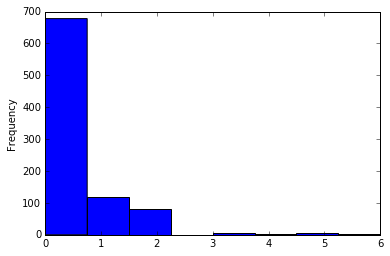

In [15]:
train['Parch'].plot.hist(bins = 8)

range between 0 and 6. most of the passangers wasn't joined by parents or children

In [23]:
train.pivot_table(index = ['SibSp','Survived'], values = [], aggfunc = len)

SibSp  Survived
0      0           398
       1           210
1      0            97
       1           112
2      0            15
       1            13
3      0            12
       1             4
4      0            15
       1             3
5      0             5
8      0             7
dtype: int64

The most chance to survive had passangers with one sibling or spouse

In [24]:
train.pivot_table(index = ['Parch','Survived'], values = [], aggfunc = len)

Parch  Survived
0      0           445
       1           233
1      0            53
       1            65
2      0            40
       1            40
3      0             2
       1             3
4      0             4
5      0             4
       1             1
6      0             1
dtype: int64

Chances to survive are increasing with number of parents or children on board

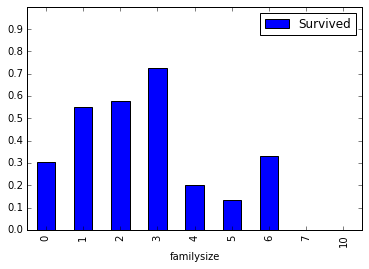

In [26]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

only 30% of the passengers who had no family members onboard survived

### Engineering New Features

In [50]:
#create new variable 'isalone', that equals to 1 if passanger were alone
def new_feature(df):
    df['isalone'] = 0
    df.loc[(df['SibSp'] + df['Parch']) == 0,'isalone'] = 1
    return df
train = new_feature(train)
holdout = new_feature(holdout)

In [51]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,Sex_female,Sex_male,isalone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1,0,0,0,0,0,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,1,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1,0,0,0,0,0,0,1,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,1,0,1,1


### Selecting the Best-Performing Features

In [52]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

In [65]:
#function for selecting features
def select_features(df):
    df = df.select_dtypes(include = [np.number])
    df.dropna(inplace = True, axis = 1)
    all_X = df.drop(['Survived', 'PassengerId'], axis = 1)
    all_y = df['Survived']
    rfc = RandomForestClassifier(random_state = 1)
    selector = RFECV(rfc,cv=10)
    selector.fit(all_X,all_y)
    print(all_X.columns[selector.support_])
    return all_X.columns[selector.support_]


In [66]:
best_columns = select_features(train)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [67]:
best_columns 

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Young Adult',
       'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'isalone'],
      dtype='object')

### Selecting and Tuning Different Algorithms

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [77]:
def select_model(df,features):
    all_X = df[features].copy()
    all_y = df['Survived'].copy()
    models = [
        {"name": "KNeighborsClassifier",
         "estimator": KNeighborsClassifier(),
         "hyperparameters":
         {
             "n_neighbors": range(1,20,2),
             "weights": ["distance", "uniform"],
             "algorithm": ["ball_tree", "kd_tree", "brute"],
             "p": [1,2]
         }},
        {"name": "LogisticRegression",
         "estimator": LogisticRegression(),
         "hyperparameters":
         {
             "solver": ["newton-cg", "lbfgs", "liblinear"]
         }},
        {"name": "RandomForestClassifier",
         "estimator": RandomForestClassifier(),
         "hyperparameters":
         {
             "n_estimators": [4, 6, 9],
             "criterion": ["entropy", "gini"],
             "max_depth": [2, 5, 10],
             "max_features": ["log2", "sqrt"],
             "min_samples_leaf": [1, 5, 8],
             "min_samples_split": [2, 3, 5]
         }}
    ]
    for i in models:
        print(i['name'])
        grid = GridSearchCV(i['estimator'],param_grid = i['hyperparameters'],cv=10)
        grid.fit(all_X,all_y)
        i['best_params'] = grid.best_params_
        i['best_score'] = grid.best_score_
        i['best_estimator'] = grid.best_estimator_
        print(grid.best_params_ , grid.best_score_)
    return models    


In [78]:
model = select_model(train,best_columns)

KNeighborsClassifier
{'n_neighbors': 5, 'p': 1, 'algorithm': 'brute', 'weights': 'uniform'} 0.7755331088664422
LogisticRegression
{'solver': 'liblinear'} 0.8204264870931538
RandomForestClassifier
{'min_samples_split': 3, 'max_depth': 10, 'n_estimators': 9, 'criterion': 'entropy', 'min_samples_leaf': 1, 'max_features': 'log2'} 0.8395061728395061


In [80]:
be = model[2]['best_estimator']

In [81]:
predictions = be.predict(holdout[best_columns])

In [83]:
submission = pd.DataFrame(holdout['PassengerId'])
submission['Survived'] = predictions
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [ ]:
submission['Sur']

In [ ]:
submission.to_csv('submission_final.csv', index = False)